$\newcommand{\ra}{\rightarrow}$
# Steane's Code under Random Pauli Error

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np
import matplotlib.pyplot as plt

Logical zero of Steane's Code is given by a uniform distribution on the eight components listed in `codewords` below, whose negation gives logical one.\
`encode(bit)` creates a circuit that prepares a $7$-digit default all-zero state into Steane's logical zero or one as specified by `bit`.

In [2]:
codewords = [
        '0000000', '0001111', '0110011', '0111100',
        '1010101', '1011010', '1100110', '1101001'
    ]

def encode(bit):
    circ = QuantumCircuit(7)
    
    state = Statevector.from_label('0000000')
    for cw in codewords[1:]:
        state += Statevector.from_label(cw)
    state = state/np.sqrt(8)

    circ.initialize(state)
    if bit:
        circ.x(range(7))
    return circ

Statevector(encode(0)).draw("Latex")

<IPython.core.display.Latex object>

`Pauli(p)` randomly selects a position `loc` among $7$ digits and places a Pauli gate according to a random bit `dice` from $(0,1)$.\
`dice`$\in(0,p)~\ra~X$ gate, `dice`$\in(p,2p)~\ra~Y$ gate, `dice`$\in(2p,3p)~\ra~Z$ gate, `dice`$\in(3p,1)~\ra$ no error.

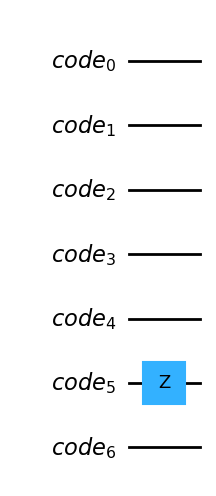

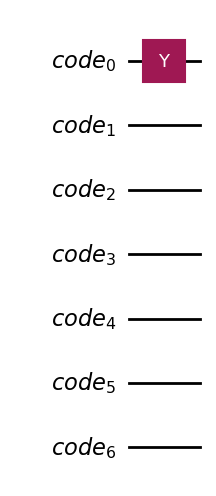

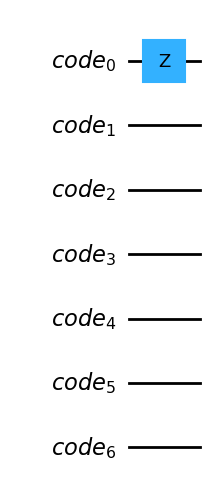

In [3]:
def Pauli(p):
    code = QuantumRegister(size=7, name="code")
    circ = QuantumCircuit(code, name="Pauli")
    loc = np.random.randint(7)
    dice = np.random.uniform(0,1)
    if dice < p:
        circ.x(loc)
    elif dice < 2*p:
        circ.y(loc)
    elif dice < 3*p:
        circ.z(loc)
    return circ

# test Pauli(p)
for i in range(3):
    display(Pauli(0.3).draw(output="mpl"))

`check()` detects $X$ and $Z$ errors, then store with $3$-digit ancilla registers respectively.

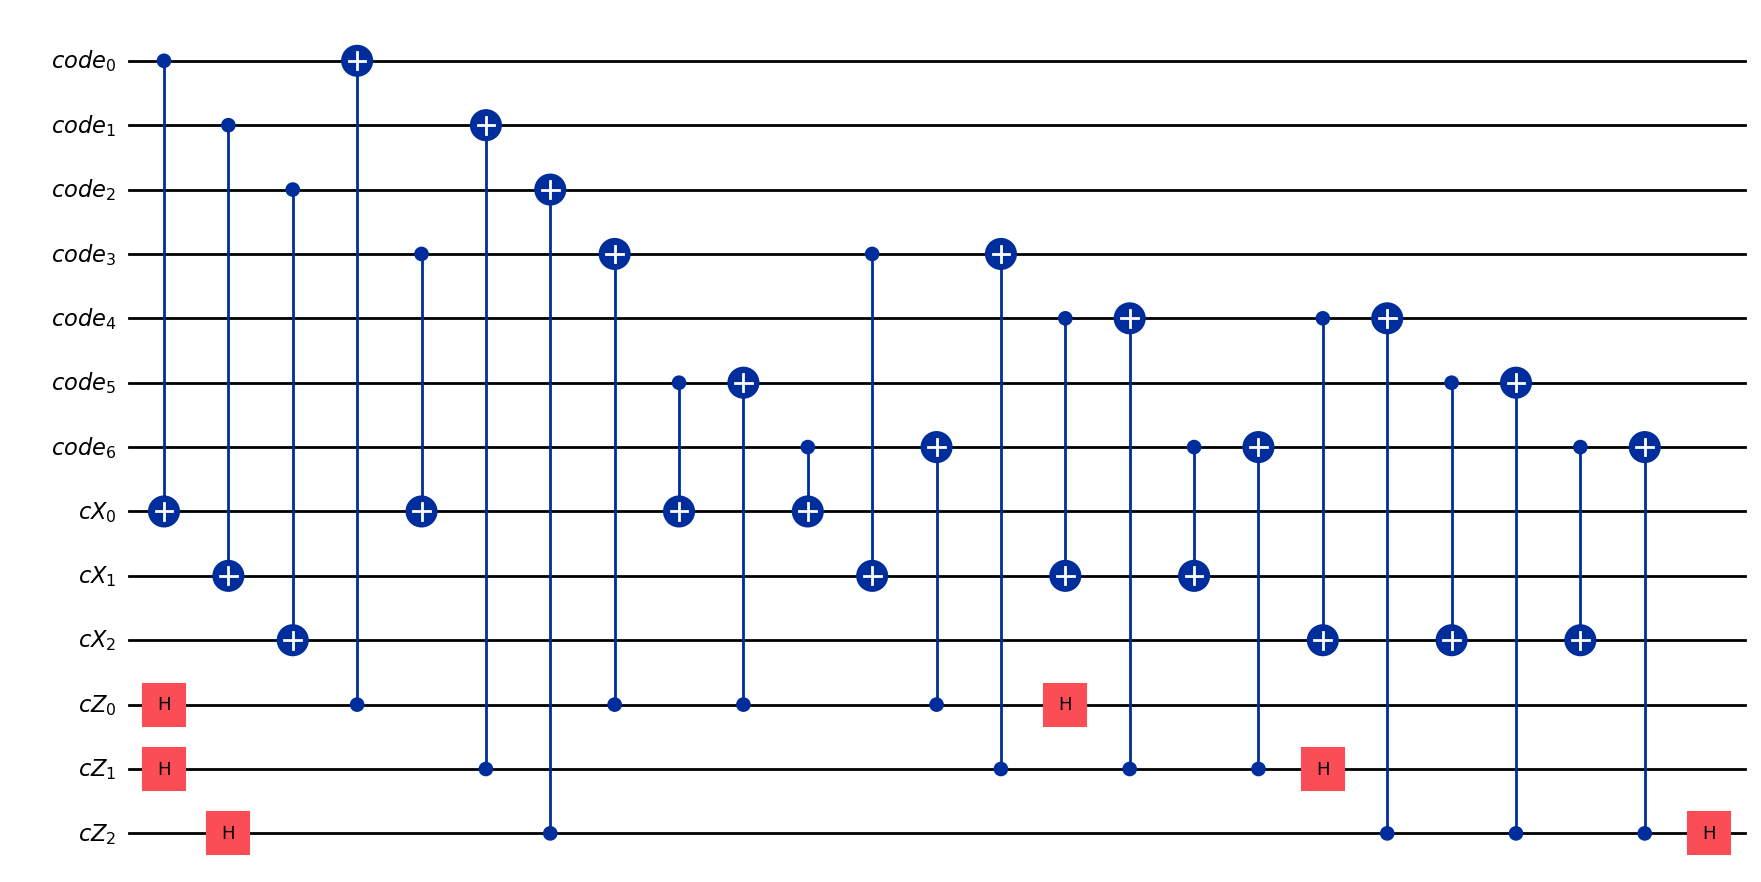

In [4]:
def check():
    code = QuantumRegister(size=7, name="code")
    Xcheck = AncillaRegister(size=3, name="cX")
    Zcheck = AncillaRegister(size=3, name="cZ")
    
    circ = QuantumCircuit(code, name="check")
    circ.add_register(Xcheck, Zcheck)
    
    H = np.array([[1, 0, 0, 1, 0, 1, 1],
                [0, 1, 0, 1, 1, 0, 1],
                [0, 0, 1, 0, 1, 1, 1]])
    
    for idx, row in enumerate(H):
        circ.h(Zcheck[idx])
        for qubit in np.where(row)[0]:
            circ.cx(qubit, Xcheck[idx]) # X check
            circ.cx(Zcheck[idx], qubit) # Z check
        circ.h(Zcheck[idx])
    return circ

check().draw(output="mpl")

`syndrome()` measures the ancilla checkers to obtain error sydrome with classical bits.

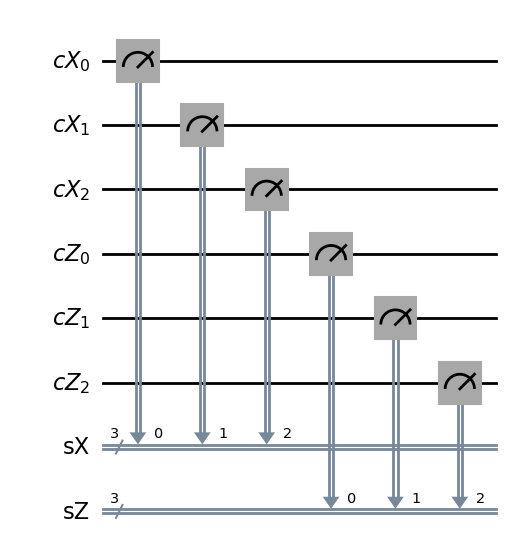

In [5]:
def syndrome():
    Xcheck = AncillaRegister(size=3, name="cX")
    Zcheck = AncillaRegister(size=3, name="cZ")
    Xsyndrome = ClassicalRegister(3, name="sX")
    Zsyndrome = ClassicalRegister(3, name="sZ")
    
    circ = QuantumCircuit(Xcheck, Zcheck, name="syndrome")
    circ.add_register(Xsyndrome, Zsyndrome)
    
    circ.measure(Xcheck, Xsyndrome)
    circ.measure(Zcheck, Zsyndrome)
    return circ

syndrome().draw(output="mpl")

`fix()` recover data from errors based on syndrome.

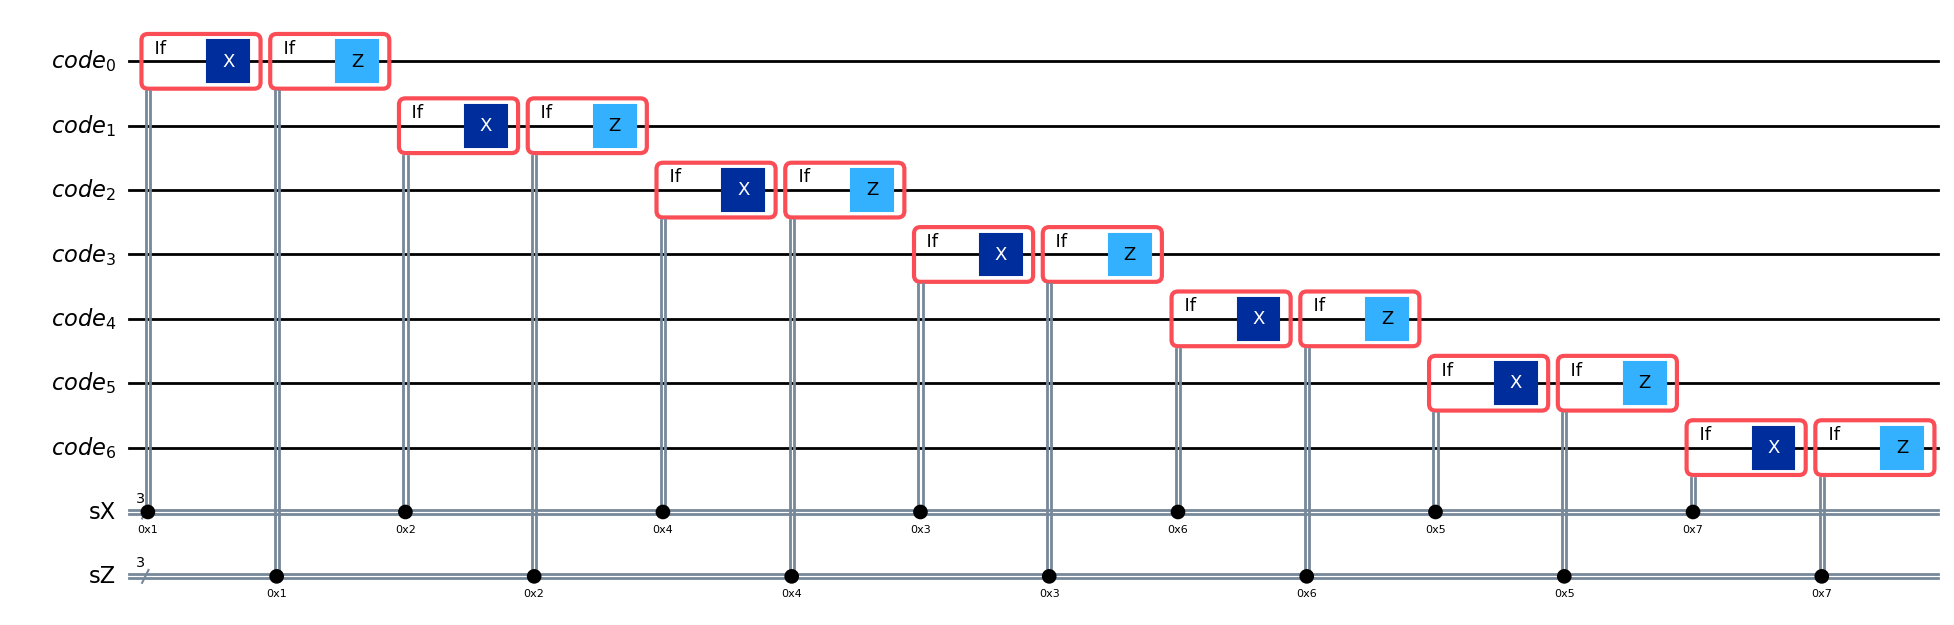

In [6]:
def fix():
    code = QuantumRegister(size=7, name="code")
    circ = QuantumCircuit(code, name="fix")
    
    Xsyndrome = ClassicalRegister(3, name="sX")
    Zsyndrome = ClassicalRegister(3, name="sZ")
    circ.add_register(Xsyndrome, Zsyndrome)
    
    checklist = [1,2,4,3,6,5,7]
    
    for i in range(7):
        # add the X checks
        with circ.if_test((Xsyndrome, checklist[i])):
            circ.x(i)
        # add the Z checks
        with circ.if_test((Zsyndrome, checklist[i])):
            circ.z(i)
        
    return circ

fix().draw(output="mpl", fold=50)

`decode` measures the recovered data.\
Note: the "decoded" data are still in Steane's Code and should be further rounded to classical $0$ or $1$ based on the logical codewords.

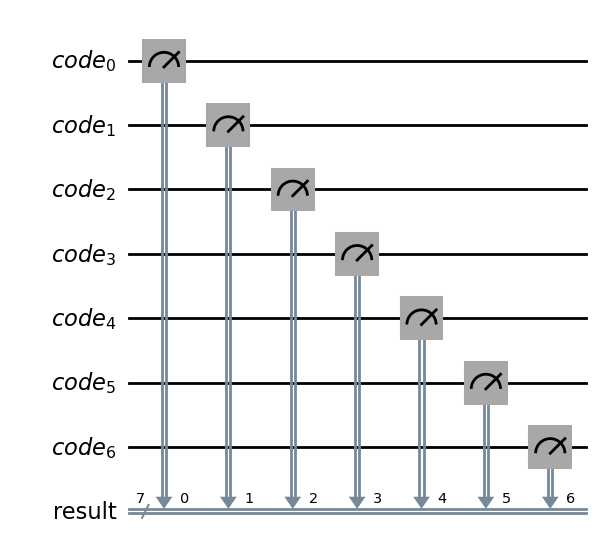

In [7]:
def decode():
    code = QuantumRegister(size=7, name="code")
    circ = QuantumCircuit(code, name="decode")

    result = ClassicalRegister(7, name="result")
    circ.add_register(result)
    circ.measure(range(7), result)
    return circ

decode().draw(output="mpl")

`SteaneBit` combines all functions above. It initializes the Steane code for each input classical boolean bit, applies a Pauli Channel with probability $p$, then corrects and stores the recovered code in $7$-digit classical register `result`.

C:\ProgramData\anaconda3\Lib\site-packages\qiskit\circuit\quantumcircuit.py:3808: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


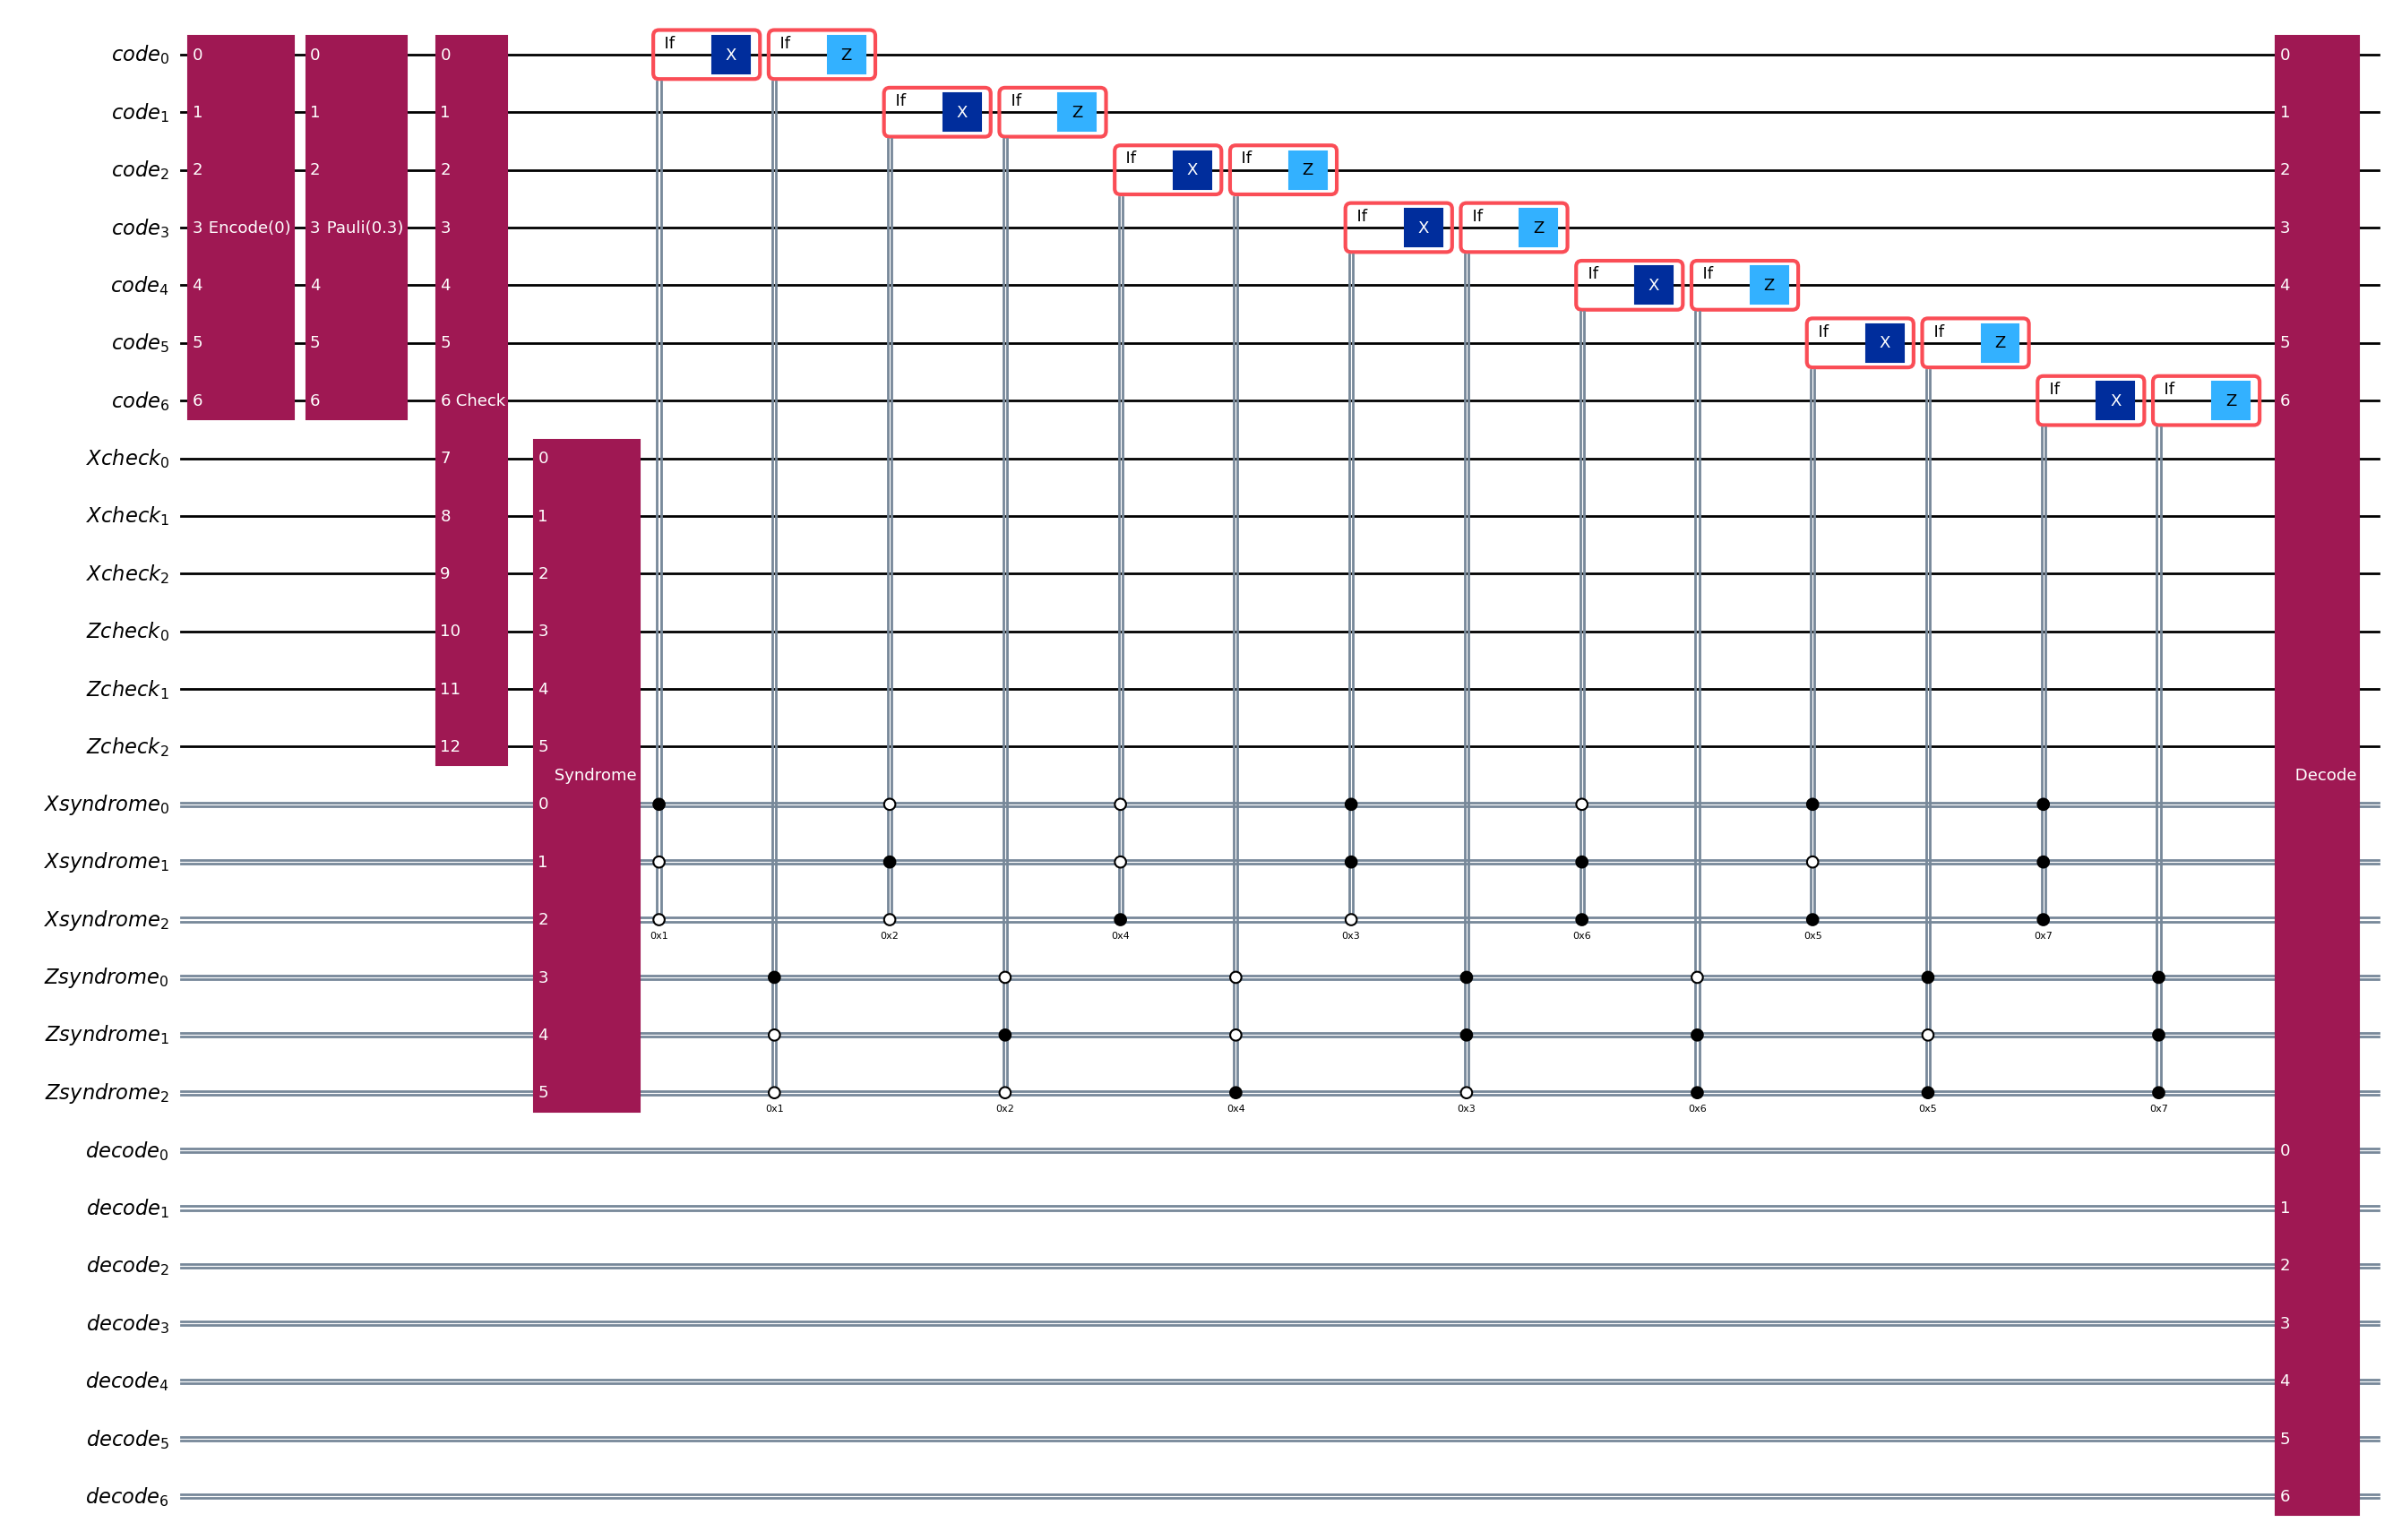

In [8]:
def SteaneBit(p, bit):
    code = QuantumRegister(size=7, name="code")
    circ = QuantumCircuit(code, name="Steane")

    encodeInst = encode(bit).to_instruction(label=" Encode({})".format(bit))
    circ.compose(encodeInst, inplace=True)

    PauliGate = Pauli(p).to_gate(label=" Pauli({})".format(p,"%.2f"))
    circ.compose(PauliGate, inplace=True)

    Xcheck = AncillaRegister(size=3, name="Xcheck")
    Zcheck = AncillaRegister(size=3, name="Zcheck")
    circ.add_register(Xcheck, Zcheck)
    checkGate = check().to_gate(label=" Check")
    circ.compose(checkGate, inplace=True)

    Xsyndrome = ClassicalRegister(3, name="Xsyndrome")
    Zsyndrome = ClassicalRegister(3, name="Zsyndrome")
    circ.add_register(Xsyndrome, Zsyndrome)
    syndromeInst = syndrome().to_instruction(label=" Syndrome")
    circ.compose(syndromeInst, qubits=Xcheck[:]+Zcheck[:], inplace=True)

    circ.compose(fix(), qubits=code, inplace=True)

    result = ClassicalRegister(7, name="decode")
    circ.add_register(result)
    decodeInst = decode().to_instruction(label=" Decode")
    circ.compose(decodeInst, qubits=code, clbits=result, inplace=True)

    return circ

SteaneBit(0.3, 0).draw(output="mpl", fold=50)

Now `SteaneBit` is passed to simulator for $100$ rounds and $100$ different $p\in(0,1/3)$. The success rate `Succ`, which is the count of measuring one component of the logical zero `codewords` divided by `rounds`, is expected to be decreasing as $p$ grows, but should not be less than $1/2$.

In [9]:
simulator = AerSimulator()
rounds = 100; pSize=100
P = np.linspace(0, 1/3, num=pSize, endpoint=False)
Succ = []

for i in range(pSize):
    # Transpile the circuit for the backend
    compiled_circuit = transpile(SteaneBit(P[i], 0), simulator)
    # Run the circuit
    job = simulator.run(compiled_circuit, shots=rounds)
    # Get the measurement counts
    counts = job.result().get_counts()
    
    distribution = {}
    for measurement in counts:
        if measurement[:7] in distribution:
            distribution[measurement[:7]] += counts[measurement] / rounds
        else:
            distribution[measurement[:7]] = counts[measurement] / rounds
    
    Succ.append(sum([distribution[cw]for cw in codewords if cw in distribution.keys()]))

`Succ` is plotted below. It appears to be quite random and can drop below $1/2$. This result shows something must go wrong above.

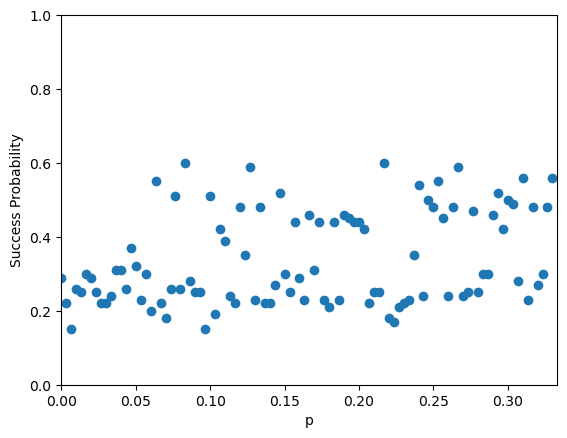

In [10]:
fig, ax = plt.subplots()
ax.scatter(P, Succ)
ax.set(xlim=(0, 1/3), ylim=(0,1), xlabel='p', ylabel='Success Probability')
plt.show()

`Steane(x,p)` is the final function that encodes each entry of $x$ by Steane' code and apply Pauli error with probability $p$.

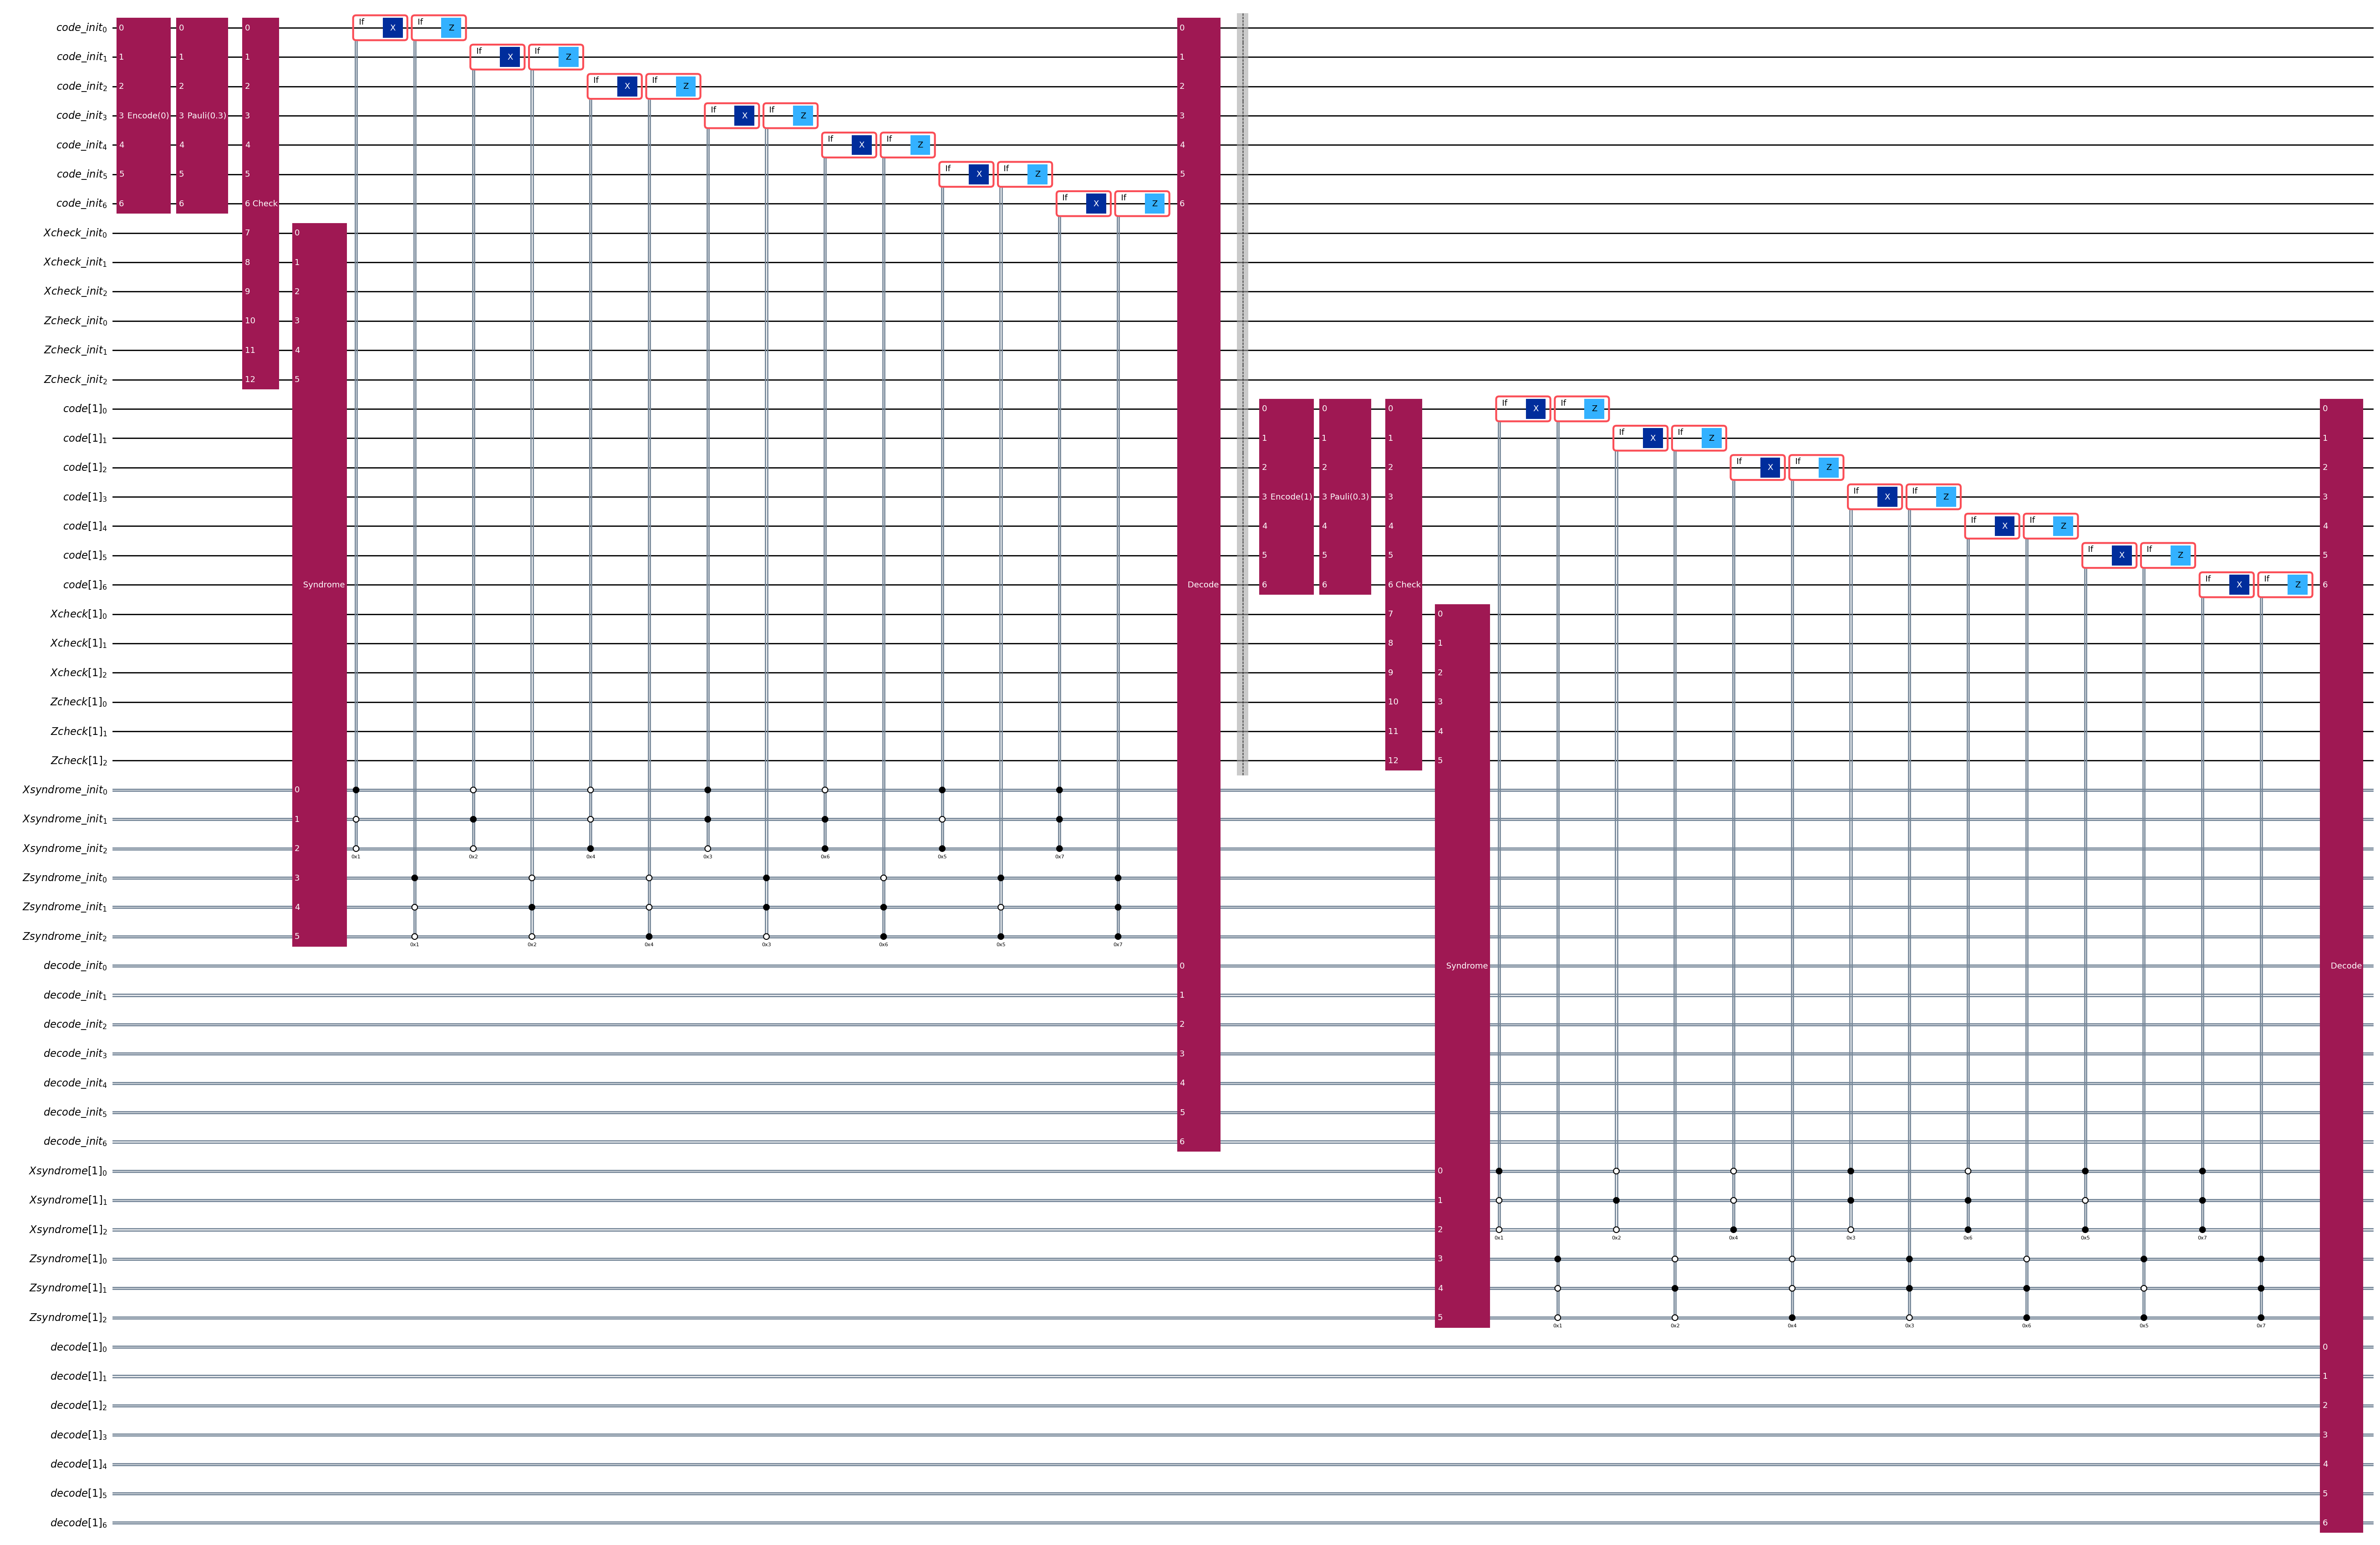

In [11]:
def Steane(x, p):
    n = len(x)
    code = QuantumRegister(size=7, name="code_init")
    circ = QuantumCircuit(code, name="Steane")
    Xcheck = AncillaRegister(size=3, name="Xcheck_init")
    Zcheck = AncillaRegister(size=3, name="Zcheck_init")
    Xsyndrome = ClassicalRegister(3, name="Xsyndrome_init")
    Zsyndrome = ClassicalRegister(3, name="Zsyndrome_init")
    result = ClassicalRegister(7, name="decode_init")
    circ.add_register(Xcheck, Zcheck, Xsyndrome, Zsyndrome, result)
    circ.compose(SteaneBit(p, x[0]), qubits=code[:]+Xcheck[:]+Zcheck[:], clbits=Xsyndrome[:]+Zsyndrome[:]+result[:], inplace=True)

    for i in range(1,n):
        code = QuantumRegister(size=7, name="code[{}]".format(i))
        Xcheck = AncillaRegister(size=3, name="Xcheck[{}]".format(i))
        Zcheck = AncillaRegister(size=3, name="Zcheck[{}]".format(i))
        Xsyndrome = ClassicalRegister(3, name="Xsyndrome[{}]".format(i))
        Zsyndrome = ClassicalRegister(3, name="Zsyndrome[{}]".format(i))
        result = ClassicalRegister(7, name="decode[{}]".format(i))
        circ.add_register(code, Xcheck, Zcheck, Xsyndrome, Zsyndrome, result)
        circ.barrier()
        circ.compose(SteaneBit(p, x[i]), qubits=code[:]+Xcheck[:]+Zcheck[:], clbits=Xsyndrome[:]+Zsyndrome[:]+result[:], inplace=True)
    
    return circ

Steane([0,1], 0.3).draw(output="mpl", fold=100)